### Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, WhitespaceTokenizer, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from pprint import pprint
nltk.download('stopwords')
nltk.download('wordnet')
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# LDAvis
import pyLDAvis
# import pyLDAvis.gensim  - old version!!!
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
# spacy for lemmatization
import spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
stop_words = stopwords.words('russian')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
!pip install pyLDAvis
!pip install gensim

  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.25.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [24]:
!pip install pandas==1.5.3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


### Загрузка и просмотр данных

In [3]:
df = pd.read_csv('banks.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bank_href,login,review,bank_name,site,date,message_href,score,status,user_href
0,/kredit-evropa-bank.html,NaN,"Брал кредит в данной организации, после погаше...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN
1,/kredit-evropa-bank.html,NaN,"В 2011 году,мною была оформлена мега карта в Т...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN


Аналогично лабораторным №1, №2 выберем один банк и применим к столбцу с отзывами все преобразовательные манипуляции

In [5]:
df_review = df[df['bank_name'] == 'сбербанк']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df_review = df_review[['review', 'score']].dropna(axis = 'index')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df_review.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2092, 2)

In [8]:
# Изменяем индексацию, не сохраняя текущий индекс
df_review.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
reviews = df_review['review']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
reviews[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\n\t\t17 октября 2018 года было произведено досрочное погашение ипотечного кредита (кредитный договор № 808299 от 22.11.2013 года) в отделении Сбербанка №9040/01300 по адресу 141002, г. Мытищи, пр-т Ново-Мытищинский, 5, 1. В этот же день 17 октября 2018 года было написано заявление о снятии обременения с квартиры. На официальном сайте банка, сказано, что Банк обязан выдать закладную в течении 30 дней. На сегодняшнее число 22.01.2019 года закладная банком НЕ ВЫДАНА.\xa0 Прошло уже 97 дней!При обращении к сотрудникам банка о выдаче закладной, они просят подождать еще 3 недели!Прошу разобраться в сложившийся ситуации и оказать помощь\xa0по снятию обременения и выдаче закладной в кратчайшие сроки.\n\t'

### Предобработка данных

In [11]:
# Токенизация
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(reviews))

print(data_words[50])
print(len(data_words))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['января', 'личном', 'кабинете', 'сбербанк', 'онлаин', 'оформил', 'потребительскии', 'кредит', 'было', 'несколько', 'звонков', 'от', 'сотрудников', 'после', 'чего', 'он', 'был', 'предварительно', 'одобрен', 'мне', 'было', 'предложено', 'приити', 'документами', 'любое', 'отделение', 'января', 'пришел', 'отделение', 'курск', 'ул', 'деинеки', 'там', 'сотрудница', 'кредитного', 'отдела', 'сказала', 'что', 'хоть', 'меня', 'висит', 'личном', 'кабинете', 'заявка', 'из', 'за', 'какого', 'то', 'технического', 'сбоя', 'она', 'эту', 'заявку', 'отредактировать', 'не', 'может', 'предложила', 'создать', 'новую', 'заявку', 'отделении', 'ее', 'помощью', 'отправить', 'опять', 'на', 'одобрение', 'согласился', 'она', 'ввела', 'данные', 'отправили', 'этого', 'момента', 'никаких', 'звонков', 'больше', 'не', 'было', 'непонятно', 'одобрили', 'его', 'второи', 'раз', 'или', 'нет', 'связаться', 'банком', 'нет', 'никакои', 'возможности', 'по', 'номеру', 'отвечает', 'робот', 'написал', 'обращение', 'личном', 'каб

In [12]:
# Определим модели с построением биграм и триграм
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=100) # higher threshold =>> fewer number of bigrams.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
!python -m spacy download ru_core_news_sm
nlp = spacy.load("ru_core_news_sm")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 27.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
# Опишем функцию для удаления стоп-слов, создания биграм и триграм, а также лемматизации
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Удаляем стоп-слова
data_words_nostops = remove_stopwords(data_words)

# Формируем биграммы
data_words_bigrams = make_bigrams(data_words_nostops)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


При лемматизации оставим существительные, глаголы, прилагательные и наречия, поскольку они будут вносить наибольший смысловой вклад в отзыв

In [19]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['межрегиональный', 'успешный', 'сделка', 'электронная_регистрация', 'проходить', 'офисе', 'покупатель', 'находиться', 'продавец', 'сложность', 'квартира', 'находиться', 'обременение', 'ипотечный', 'квартира', 'сделка_прошла', 'короткии', 'срок', 'быстро', 'надежно', 'безопасный', 'нашему_менеджеру', 'катерина', 'тужилкинои', 'банк', 'целом']


На вход модели LDA необходимо подать словарь (id2word) и корпус из слов. Создадим их.

In [20]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


Получаем на выходе корпус встречаемости слов: каждому слову соответствует индекс (первое число) и встречаемость в рассматриваемом документе (второе число)

In [21]:
print(corpus[1])

[(0, 4), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 2), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Посмотрим на слово с индексом "0":

In [22]:
id2word[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'банк'

In [23]:
# Проверим, совпадает ли размерность корпуса с количеством отзывов
len(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2092

In [24]:
# Посмотрим на встречаемость слов в последнем отзыве
[[(id2word[id], freq) for id, freq in enumerate(cp)] for cp in corpus[:1]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('банк', (0, 1)),
  ('деньга', (1, 1)),
  ('другои', (2, 1)),
  ('завтра', (3, 1)),
  ('закрывать', (4, 1)),
  ('зарплата', (5, 1)),
  ('идти', (6, 1)),
  ('имеют_право', (7, 1)),
  ('каком_основании', (8, 1)),
  ('карта', (9, 1)),
  ('кредитнои', (10, 1)),
  ('мама', (11, 2)),
  ('объяснить', (12, 1)),
  ('пенсия', (13, 2)),
  ('перевести', (14, 1)),
  ('переводить', (15, 1)),
  ('плакать', (16, 1)),
  ('плохо', (17, 1)),
  ('своеи', (18, 1)),
  ('сегодня', (19, 1)),
  ('снять', (20, 1)),
  ('сторона', (21, 1)),
  ('счёт', (22, 2)),
  ('творить', (23, 1)),
  ('трясти', (24, 1)),
  ('ужасныи', (25, 1)),
  ('хотеть', (26, 1)),
  ('часть', (27, 1))]]

### Тематическое моделирование


LDA, или Latent Dirichlet Allocation, является популярным алгоритмом машинного обучения без учителя для анализа текстов и автоматического выявления тем в больших коллекциях документов. Он был представлен Дэвидом Блеем и его коллегами в 2003 году. LDA основан на предположении, что документы состоят из нескольких тем, а темы характеризуются распределением слов.

Основные концепции LDA:

Документы: В контексте LDA, документом может быть любой текстовый объект, от предложения до большой статьи.

Темы: Абстрактные тематические категории, которые LDA пытается обнаружить из набора документов. Каждая тема характеризуется набором слов, которые часто встречаются вместе.

Распределение тем в документах: LDA моделирует каждый документ как смесь различных тем. Это значит, что каждый документ связан с набором тем в определённых пропорциях.

Распределение слов в темах: LDA также определяет, какие слова наиболее вероятно встречаются в каждой теме.

In [25]:
# Инициализируем модель
'''Подаём на вход полученные словарь и корпус, устанавливаем
количество тем и повторяемость эксперимента'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Посмотрим на ключевые слова для полученных тем
#pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Перплексия
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#Когерентность
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -11.374954261939791

Coherence Score:  0.48087574318613174


### Выбор наилучшего количества тем

Для определения наилучшего количества тем, реализуем цикл с инициализацией модели и вычислением перплексии и когерентности:

In [37]:
# Диапазон количества тем
min_topics = 3
max_topics = 25

# Словарь для хранения значений метрик
model_results = {'Topics': [],
                 'Perplexity': [],
                 'Coherence': []}

# Цикл по количеству тем
for num_topics in range(min_topics, max_topics + 1):
    # Обучение модели LDA
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    # Вычисление перплексии
    perplexity = lda_model.log_perplexity(corpus)

    # Вычисление когерентности
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Сохранение результатов
    model_results['Topics'].append(num_topics)
    model_results['Perplexity'].append(perplexity)
    model_results['Coherence'].append(coherence_lda)

    print(f"Num Topics: {num_topics}, Perplexity: {perplexity}, Coherence: {coherence_lda}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num Topics: 3, Perplexity: -8.014945359783397, Coherence: 0.37639838451143276
Num Topics: 4, Perplexity: -8.046915270476891, Coherence: 0.36175496713764044
Num Topics: 5, Perplexity: -8.09362284502455, Coherence: 0.4602565673739747
Num Topics: 6, Perplexity: -8.152209185930067, Coherence: 0.4457971926310997
Num Topics: 7, Perplexity: -8.216040202384644, Coherence: 0.45098013884513755
Num Topics: 8, Perplexity: -8.314464643217324, Coherence: 0.42792588374497254
Num Topics: 9, Perplexity: -8.482282039623083, Coherence: 0.49811224588183123
Num Topics: 10, Perplexity: -8.732194594882504, Coherence: 0.4969271813688594
Num Topics: 11, Perplexity: -9.143328740999994, Coherence: 0.45536133051007377
Num Topics: 12, Perplexity: -9.670524579060494, Coherence: 0.4708248345251185
Num Topics: 13, Perplexity: -10.444575579734508, Coherence: 0.507940797166571
Num Topics: 14, Perplexity: -11.073127668575104, Coherence: 0.4634878695027481
Num Topics: 15, Perplexity: -11.374954261939791, Coherence: 0.480

### Модель с 17 темами

In [39]:
# Инициализируем модель с выбранным количеством тем
'''Подаём на вход полученные словарь и корпус, устанавливаем
количество тем и повторяемость эксперимента'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=17,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Визуализация тем
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.328269  0.200363       1        1  26.706952
2      0.344382  0.059340       2        1  19.354290
15     0.305929  0.158024       3        1  15.430403
0      0.277887 -0.287822       4        1  15.289558
11     0.276958 -0.176397       5        1  15.230462
14    -0.093437  0.008640       6        1   1.699180
13    -0.101262  0.004928       7        1   1.646501
3     -0.125244  0.002708       8        1   0.936585
6     -0.125975  0.003504       9        1   0.796648
7     -0.133126  0.003508      10        1   0.570344
10    -0.134235  0.003452      11        1   0.469691
9     -0.134601  0.003446      12        1   0.465068
12    -0.134233  0.003458      13        1   0.450527
1     -0.136742  0.003359      14        1   0.368673
5     -0.138235  0.003233      15        1   0.225897
16    -0.138103  0.003147      16        1   0.185797
4     -0.138232  0.003112      17        1   0.173426, topic_info=           Term         Freq        Total Category  logprob  loglift
9         карта  3431.000000  3431.000000  Default  30.0000  30.0000
1        деньга  2880.000000  2880.000000  Default  29.0000  29.0000
320      кредит  1332.000000  1332.000000  Default  28.0000  28.0000
52    отделение  2256.000000  2256.000000  Default  27.0000  27.0000
150      клиент  1444.000000  1444.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
6022  интересно     0.015090     0.845603  Topic17  -9.8303   2.3312
3633     забота     0.015090     0.845554  Topic17  -9.8303   2.3312
3034   сведение     0.015091     0.845886  Topic17  -9.8303   2.3309
3771     кассир     0.015092     0.846731  Topic17  -9.8302   2.3300
4700       дочь     0.015091     0.845900  Topic17  -9.8303   2.3309

[710 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
999       5  0.991556       август
2800     12  0.910115   адекватный
28        3  0.481896        адрес
28        4  0.208303        адрес
28        5  0.307792        адрес
...     ...       ...          ...
2395      8  0.932992  этим_банком
375       1  0.355582     являться
375       5  0.640048     являться
1528      5  0.990993        якобы
2906     11  0.897557         ясно

[764 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 16, 1, 12, 15, 14, 4, 7, 8, 11, 10, 13, 2, 6, 17, 5])

### Анализ результатов

Визуализируем метрику когерентности с увеличением выделяемых тем:

In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2
8
14
20
26


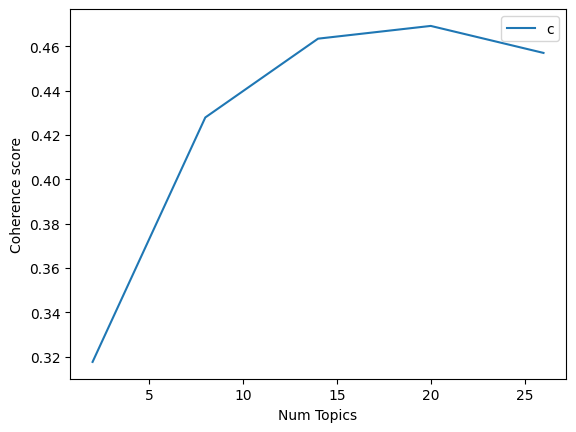

In [36]:
# Evaluete optimal num_topics. Long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=6)

# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Из полученных данных видно, как изменяются перплексия и когерентность в зависимости от количества тем. Для выбора оптимального количества тем важно найти баланс между низкой перплексией и высокой когерентностью, так как перплексия измеряет степень удивления модели при виде тестовых данных, а когерентность оценивает степень семантической связности слов в темах.

Результаты показывают следующее:

*   Наилучший баланс по метрикам достигается при 17 темах (0.49), что указывает на хорошую семантическую связность слов в темах на этом уровне. Это означает, что модель с 17 темами обладает хорошей интерпретируемостью.
*   После 17 тем перплексия продолжает ухудшаться (увеличиваться по модулю отрицательного значения), что свидетельствует о продолжающемся улучшении способности модели описывать данные, однако это также может указывать на переобучение, когда модель слишком подробно подгоняется под обучающие данные.

Таким образом, оптимальное количество тем для модели, исходя из сочетания хорошей интерпретируемости (высокая когерентность) и способности модели адекватно описывать данные без переобучения (умеренная перплексия), скорее всего, составляет 17 тем.

Для анализа полученных тем посмотрим на свойственные каждой теме слова

In [40]:
top_words_per_topic = lda_model.print_topics(num_words=10)
for topic_number, topic in enumerate(top_words_per_topic):
    print(f"Тема {topic_number + 1}:")
    print(topic)
    print("\n")

Тема 1:
(0, '0.116*"деньга" + 0.030*"банкомат" + 0.024*"счёт" + 0.019*"номер" + 0.018*"операция" + 0.018*"сумма" + 0.018*"вернуть" + 0.017*"снять" + 0.017*"рублеи" + 0.015*"средство"')


Тема 2:
(1, '0.050*"вызвать" + 0.025*"впервые" + 0.022*"возникать" + 0.017*"отличный" + 0.016*"готовность" + 0.013*"книгу_жалоб" + 0.009*"тяжёлый" + 0.008*"приятно_удивлена" + 0.007*"повторить" + 0.007*"всячески"')


Тема 3:
(2, '0.043*"кредит" + 0.042*"банк" + 0.037*"год" + 0.032*"сказать" + 0.023*"день" + 0.019*"сумма" + 0.019*"месяц" + 0.015*"платёж" + 0.015*"взять" + 0.013*"заявка"')


Тема 4:
(3, '0.032*"приходиться" + 0.024*"акция" + 0.018*"обратно" + 0.017*"проживать" + 0.017*"своим_клиентам" + 0.015*"навязывание" + 0.014*"недовольный" + 0.014*"специально" + 0.014*"премия" + 0.013*"талончик"')


Тема 5:
(4, '0.020*"набирать" + 0.016*"кража" + 0.013*"задача" + 0.012*"редко" + 0.010*"экран" + 0.008*"скорость" + 0.008*"буду_рекомендовать" + 0.005*"владимировна" + 0.004*"скриншот" + 0.004*"лето"')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Исходя из наиболее значимых слов в каждой теме, можно попытаться дать названия темам.


1.   
Банковские операции: обсуждаются деньги, банкоматы, счета, операции и снятие средств.
2.   Сервис и обслуживание: включает отзывы о вызове сервиса, готовности и впечатлениях от обслуживания.
3. Кредитование: сфокусирована на кредитах, банках и связанных с этим процессах.
4. Маркетинговые акции и предложения: обсуждаются акции, предложения банков и отношение клиентов к ним.
5. Технические вопросы: возможно, связана с обсуждением технических аспектов банковских услуг.
6. Личный опыт и эмоции: отражает личные истории, связанные с банковскими услугами.
7. Обслуживание в офисе: касается обслуживания в кассах, обращений в банк и связанных с этим процедур.
8. Личные финансы и планирование: обсуждение семейного бюджета, запросов и финансового планирования.
9. Клиентоориентированность: сфокусирована на отношениях с клиентами и качестве обслуживания в отделениях.
10. Правовые вопросы и регулирование: может касаться правовых аспектов взаимодействия с банком.
11. Безопасность и конфиденциальность: обсуждение вопросов безопасности и защиты информации.
12. Документооборот и обращения: связана с процессами подачи заявлений и получения ответов от банка.
13. Обслуживание и клиентский опыт: включает в себя обсуждение качества обслуживания и отношения к клиентам.
14. Страхование и договорные отношения: касается вопросов страхования и деталей договоров.
15. Ипотека и недвижимость: обсуждение ипотеки, сделок с недвижимостью и роли менеджеров.
16. Банковские карты и счета: включает вопросы, связанные с использованием и обслуживанием банковских карт.
17. Налоги и финансовое планирование: обсуждаются налоги, платежи и управление финансами.

Попробуем связать метки классов 'score' с темами, для этого инициализируем модель с двумя темами и оценим, насколько получится разделить отзывы на положительные и отрицательные:

In [33]:
# Инициализируем модель с выбранным количеством тем
'''Подаём на вход полученные словарь и корпус, устанавливаем
количество тем и повторяемость эксперимента'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Визуализация тем
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.119625  0.0       1        1  71.975926
1     -0.119625  0.0       2        1  28.024074, topic_info=         Term         Freq        Total Category  logprob  loglift
9       карта  2543.000000  2543.000000  Default  30.0000  30.0000
1      деньга  2195.000000  2195.000000  Default  29.0000  29.0000
320    кредит   930.000000   930.000000  Default  28.0000  28.0000
150    клиент   988.000000   988.000000  Default  27.0000  27.0000
87   менеджер   366.000000   366.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
26     хотеть   154.823197   380.515356   Topic2  -5.6794   0.3729
381      офис   142.029251   359.069793   Topic2  -5.7656   0.3446
75      время   154.831112   526.610896   Topic2  -5.6793   0.0480
95   оформить   132.361653   316.701730   Topic2  -5.8361   0.3997
61    сказать   159.040537  1048.019117   Topic2  -5.6525  -0.6134

[150 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.816576           банк
0         2  0.183625           банк
124       1  0.998198       банкомат
124       2  0.001754       банкомат
2931      1  0.015749  благодарность
...     ...       ...            ...
26        2  0.407342         хотеть
667       1  0.027378  хочу_выразить
667       2  0.985615  хочу_выразить
359       1  0.530281        человек
359       2  0.468880        человек

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

Попытка не увенчалась успехом. Результаты скорее указывают на явное разделение отзывов по той или иной сфере работы банка: тема 2 - вопросы, связанные с квартирами и ипотекой; тема 1 - вопросы, связанные с работой отделений

Ответим на вопрос, связаны ли метки классов 'score' с полученными темами
Ещё раз оценим полученные темы:

In [41]:
# Визуализация тем
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.328269  0.200363       1        1  26.706952
2      0.344382  0.059340       2        1  19.354290
15     0.305929  0.158024       3        1  15.430403
0      0.277887 -0.287822       4        1  15.289558
11     0.276958 -0.176397       5        1  15.230462
14    -0.093437  0.008640       6        1   1.699180
13    -0.101262  0.004928       7        1   1.646501
3     -0.125244  0.002708       8        1   0.936585
6     -0.125975  0.003504       9        1   0.796648
7     -0.133126  0.003508      10        1   0.570344
10    -0.134235  0.003452      11        1   0.469691
9     -0.134601  0.003446      12        1   0.465068
12    -0.134233  0.003458      13        1   0.450527
1     -0.136742  0.003359      14        1   0.368673
5     -0.138235  0.003233      15        1   0.225897
16    -0.138103  0.003147      16        1   0.185797
4     -0.138232  0.003112      17        1   0.173426, topic_info=           Term         Freq        Total Category  logprob  loglift
9         карта  3431.000000  3431.000000  Default  30.0000  30.0000
1        деньга  2880.000000  2880.000000  Default  29.0000  29.0000
320      кредит  1332.000000  1332.000000  Default  28.0000  28.0000
52    отделение  2256.000000  2256.000000  Default  27.0000  27.0000
150      клиент  1444.000000  1444.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
6022  интересно     0.015090     0.845603  Topic17  -9.8303   2.3312
3633     забота     0.015090     0.845554  Topic17  -9.8303   2.3312
3034   сведение     0.015091     0.845886  Topic17  -9.8303   2.3309
3771     кассир     0.015092     0.846731  Topic17  -9.8302   2.3300
4700       дочь     0.015091     0.845900  Topic17  -9.8303   2.3309

[710 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
999       5  0.991556       август
2800     12  0.910115   адекватный
28        3  0.481896        адрес
28        4  0.208303        адрес
28        5  0.307792        адрес
...     ...       ...          ...
2395      8  0.932992  этим_банком
375       1  0.355582     являться
375       5  0.640048     являться
1528      5  0.990993        якобы
2906     11  0.897557         ясно

[764 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 16, 1, 12, 15, 14, 4, 7, 8, 11, 10, 13, 2, 6, 17, 5])

Группа тем 1-3 не содержит информации об позитивной или негативной окраске отзыва и скорее формирует группу отзывов о работе отделений (тема 1: банк, отделение, работать; тема 2: кредит, сумма, заявка; тема 3: карта, вклад, счёт).

Темы 4, 5 - обработка заявок, взаимодействие с банкоматами.

Группу тем 6-7 формируют отзывы, связанные с ипотекой и страхованием.

Однако начиная с 8 темы и вплоть до 17 темы начинают встречаться слова, отражающие негативную окраску отзыва: 8 (навязывание, недовольный), 9 (бегать, пропасть), 10 (списывать, арестовать) и тд.

То есть по меньшей мере половина тем отзывов связана с негативным опытом пользования банком. Эта половина располагается в левой части семантического пространства, в то время как в правой части семантического пространства находятся отзывы, связанные с работой отделений банка и банкоматов.

Объединим предположения, полученные в результате моделирования с двумя и семнадцатью темами:

Поскольку разделение на две темы позволило разделить отзывы на различные сферы работы банка, а разделение на семнадцать позволило выделить явно негативные отзывы (причем расположение тем в семантическом пространстве для обоих случаев сопоставимо), делаем следующий вывод: да, полученные темы связаны с метками классов, но неявно (в группе тем "справа" нет слов, явно окрашивающих отзывы в положительную окраску).

Деятельность банка "сбербанк", связанная с отделениями и банкоматами, устраивает пользователей (нет "позитивных" слов, но нет и "негативных", что позволяет делать вывод "от обратного), а деятельность, связанная с кредитованием и страхованием вызывает недовольство (темы 8-17).